In [ ]:
import os
import tensorflow as tf
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.utils import class_weight
from google.colab import drive

# 1. Mount Google Drive
drive.mount('/content/drive')

# --- CONFIGURATION: UPDATE THIS PATH ---
# Point this to where you uploaded the zip file in your Drive
ZIP_PATH = '/content/drive/MyDrive/archive.zip'
# ---------------------------------------

# 2. Copy and Unzip to Local Colab Storage
if not os.path.exists('Animals-10'):
    print(f"Copying {ZIP_PATH} to local storage...")
    !cp "{ZIP_PATH}" animals-10.zip
    print("Unzipping...")
    !unzip -q animals-10.zip -d Animals-10
    print("Done.")

# 3. Find Images and Prepare Splits
DATA_DIR = 'Animals-10/raw-img'
if not os.path.exists(DATA_DIR):
    # Fallback to find the folder if the zip structure is different
    for root, dirs, files in os.walk('Animals-10'):
        if 'cane' in dirs:
            DATA_DIR = root
            break

class_names = sorted([d for d in os.listdir(DATA_DIR) if os.path.isdir(os.path.join(DATA_DIR, d))])
print(f"Classes found: {class_names}")

image_paths = []
labels = []
class_to_index = {name: i for i, name in enumerate(class_names)}

for class_name in class_names:
    class_dir = os.path.join(DATA_DIR, class_name)
    for f in os.listdir(class_dir):
        if f.lower().endswith(('.png', '.jpg', '.jpeg')):
            image_paths.append(os.path.join(class_dir, f))
            labels.append(class_to_index[class_name])

# Stratified Split (70% Train, 15% Val, 15% Test)
X_train, X_temp, y_train, y_temp = train_test_split(
    image_paths, labels, test_size=0.30, random_state=42, stratify=labels
)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.50, random_state=42, stratify=y_temp
)

# Class Weights
class_weights_arr = class_weight.compute_class_weight(
    class_weight='balanced', classes=np.unique(y_train), y=y_train
)
class_weights = {i: w for i, w in enumerate(class_weights_arr)}

print(f"Data ready: {len(X_train)} train, {len(X_val)} val, {len(X_test)} test.")

Mounted at /content/drive
Copying /content/drive/MyDrive/archive.zip to local storage...
Unzipping...
Done.
Classes found: ['cane', 'cavallo', 'elefante', 'farfalla', 'gallina', 'gatto', 'mucca', 'pecora', 'ragno', 'scoiattolo']
Data ready: 18325 train, 3927 val, 3927 test.


In [ ]:
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input

IMAGE_SIZE = (224, 224)
BATCH_SIZE = 64
SEED = 42

# Define the augmentation layers
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal"),
    tf.keras.layers.RandomRotation(0.1),
    tf.keras.layers.RandomZoom(0.1),
], name="data_augmentation")

def load_and_preprocess_mobilenet(image_path, label):
    """Loads, decodes, and preprocesses a single image for MobileNetV2."""
    # 1. Load image
    image = tf.io.read_file(image_path)
    image = tf.io.decode_jpeg(image, channels=3)

    # 2. Resize
    image = tf.image.resize(image, IMAGE_SIZE)

    # 3. MobileNetV2 Preprocessing (scales to -1, 1)
    image = preprocess_input(image) # Use MobileNetV2's specific function

    return image, label

def build_dataset(image_paths, labels, is_training=False):
    """Builds a tf.data.Dataset pipeline."""
    ds = tf.data.Dataset.from_tensor_slices((image_paths, labels))

    if is_training:
        ds = ds.shuffle(buffer_size=len(image_paths), reshuffle_each_iteration=True)

    # Load and preprocess using the MobileNetV2 function
    ds = ds.map(load_and_preprocess_mobilenet, num_parallel_calls=tf.data.AUTOTUNE)

    if is_training:
        # Apply augmentation *after* resizing and normalization
        ds = ds.map(lambda x, y: (data_augmentation(x), y), num_parallel_calls=tf.data.AUTOTUNE)

    # Cache for speed (if memory allows)
    ds = ds.cache()

    # Batch and prefetch
    ds = ds.batch(BATCH_SIZE)
    ds = ds.prefetch(buffer_size=tf.data.AUTOTUNE)

    return ds

# Build the final datasets
train_ds = build_dataset(X_train, y_train, is_training=True)
val_ds = build_dataset(X_val, y_val, is_training=False)
test_ds = build_dataset(X_test, y_test, is_training=False)

# Get true labels for final evaluation (needed for scikit-learn metrics)
y_test_true = np.array([y.numpy() for x, y in test_ds.unbatch()])

print("MobileNetV2 Data Pipeline Ready.")

MobileNetV2 Data Pipeline Ready.


In [ ]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

# 1. Build Model
def build_mobilenet_model():
    # Load pre-trained base (weights='imagenet')
    base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
    base_model.trainable = False # Freeze base for Stage 1

    # Add new classifier head
    inputs = Input(shape=(224, 224, 3))
    x = base_model(inputs, training=False)
    x = GlobalAveragePooling2D()(x)
    x = Dropout(0.5)(x)
    outputs = Dense(10, activation='softmax')(x)

    return Model(inputs, outputs)

model = build_mobilenet_model()

# 2. STAGE 1: WARM-UP
print("\n--- STAGE 1: WARM-UP ---")
model.compile(optimizer=Adam(1e-3), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

checkpoint_1 = ModelCheckpoint('mobile_stage1.keras', save_best_only=True, monitor='val_loss')

model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=10,
    class_weight=class_weights,
    callbacks=[checkpoint_1]
)

# 3. STAGE 2: FINE-TUNING
print("\n--- STAGE 2: FINE-TUNING ---")
model.load_weights('mobile_stage1.keras') # Load best from stage 1
model.layers[1].trainable = True # Unfreeze base

# Freeze the bottom layers (MobileNetV2 has ~155 layers, unfreeze top ~30)
for layer in model.layers[1].layers[:-30]:
    layer.trainable = False

model.compile(optimizer=Adam(1e-5), loss='sparse_categorical_crossentropy', metrics=['accuracy']) # Low LR

checkpoint_2 = ModelCheckpoint('mobile_best.keras', save_best_only=True, monitor='val_loss')
early_stop = EarlyStopping(patience=5, restore_best_weights=True)

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=30,
    class_weight=class_weights,
    callbacks=[checkpoint_2, early_stop]
)

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step

--- STAGE 1: WARM-UP ---
Epoch 1/10
287/287 ━━━━━━━━━━━━━━━━━━━━ 102s 290ms/step - accuracy: 0.6632 - loss: 1.0625 - val_accuracy: 0.9470 - val_loss: 0.1859
Epoch 2/10
287/287 ━━━━━━━━━━━━━━━━━━━━ 19s 66ms/step - accuracy: 0.9020 - loss: 0.3226 - val_accuracy: 0.9554 - val_loss: 0.1575
Epoch 3/10
287/287 ━━━━━━━━━━━━━━━━━━━━ 19s 65ms/step - accuracy: 0.9189 - loss: 0.2700 - val_accuracy: 0.9534 - val_loss: 0.1582
Epoch 4/10
287/287 ━━━━━━━━━━━━━━━━━━━━ 19s 67ms/step - accuracy: 0.9228 - loss: 0.2429 - val_accuracy: 0.9570 - val_loss: 0.1473
Epoch 5/10
287/287 ━━━━━━━━━━━━━━━━━━━━ 19s 67ms/step - accuracy: 0.9223 - loss: 0.2410 - val_accuracy: 0.9598 - val_loss: 0.1400
Epoch 6/10
287/287 ━━━━━━━━━━━━━━━━━━━━ 19s 67ms/step - accuracy: 0.9262 - loss: 0.2380 - val_accuracy: 0.9608 - val_loss: 0.1379
Epoch 7/10
287/287 ━━━━━━━━━━━━━━━━━━━━ 19s 67ms/step - accuracy: 0.9297 - loss: 0.2291 - val_accuracy: 0.9585 - val_loss: 0.1367
Epoch 8/10
28

In [ ]:
import time
from sklearn.metrics import classification_report, f1_score

# Load best model
model.load_weights('mobile_best.keras')

# 1. Accuracy & F1-Score
print("Running predictions...")
logits = model.predict(test_ds)
preds = np.argmax(logits, axis=1)

print("\n--- CLASSIFICATION REPORT ---")
print(classification_report(y_test, preds, target_names=class_names))
weighted_f1 = f1_score(y_test, preds, average='weighted')
print(f"Weighted F1-Score: {weighted_f1:.4f}")

# 2. Efficiency: Model Size
total_params = model.count_params()
print(f"\n--- EFFICIENCY METRICS ---")
print(f"Total Parameters: {total_params:,}")
# (Expect ~2.2M, vs ResNet50's ~23M)

# 3. Efficiency: Inference Time
print("Measuring inference speed...")
start_time = time.time()
# Run a full pass over the test set
model.predict(test_ds)
end_time = time.time()

total_time = end_time - start_time
avg_time_per_image = (total_time / len(y_test)) * 1000 # in milliseconds

print(f"Total Inference Time (Test Set): {total_time:.2f} seconds")
print(f"Average Inference Time per Image: {avg_time_per_image:.2f} ms")

Running predictions...
62/62 ━━━━━━━━━━━━━━━━━━━━ 12s 122ms/step

--- CLASSIFICATION REPORT ---
              precision    recall  f1-score   support

        cane       0.98      0.96      0.97       730
     cavallo       0.96      0.95      0.95       393
    elefante       0.98      0.98      0.98       217
    farfalla       0.95      0.98      0.96       317
     gallina       0.99      0.97      0.98       465
       gatto       0.95      0.96      0.95       250
       mucca       0.88      0.95      0.91       280
      pecora       0.92      0.94      0.93       273
       ragno       0.99      0.98      0.98       723
  scoiattolo       0.98      0.97      0.98       279

    accuracy                           0.96      3927
   macro avg       0.96      0.96      0.96      3927
weighted avg       0.96      0.96      0.96      3927

Weighted F1-Score: 0.9638

--- EFFICIENCY METRICS ---
Total Parameters: 2,270,794
Measuring inference speed...
62/62 ━━━━━━━━━━━━━━━━━━━━ 3s 55ms


Confusion Matrix:


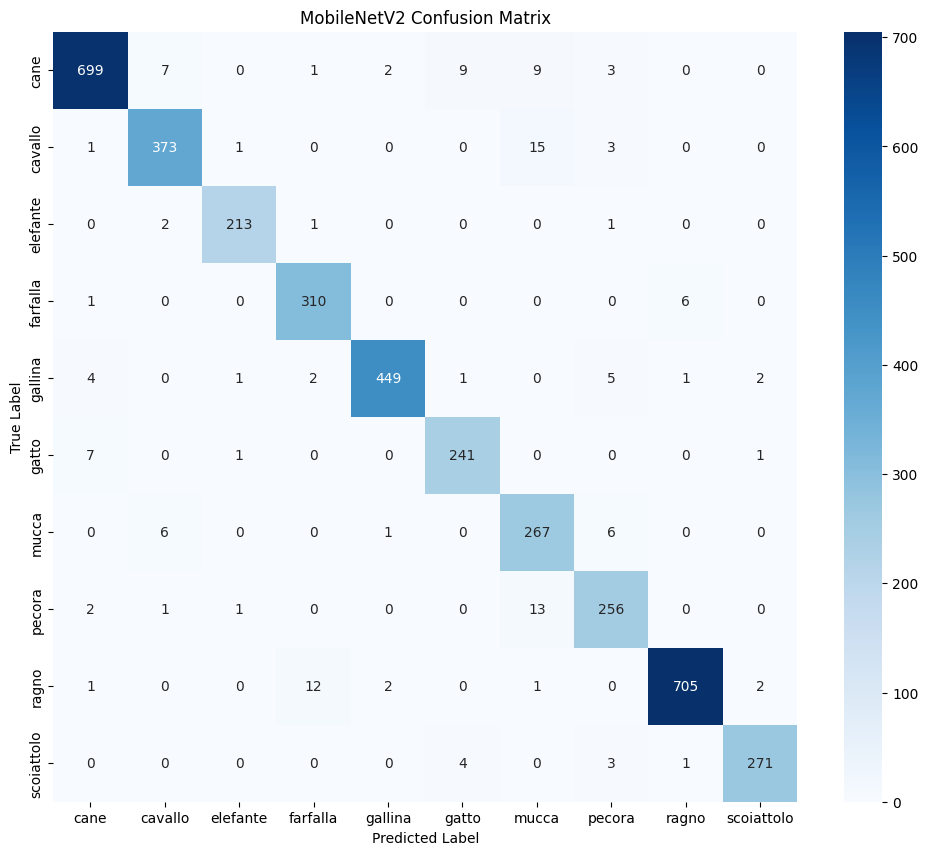

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Generate and plot Confusion Matrix
print("\nConfusion Matrix:")
cm_mobile = confusion_matrix(y_test, preds)
plt.figure(figsize=(12, 10))
sns.heatmap(cm_mobile, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.title('MobileNetV2 Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

--- Training History (Fine-Tuning Stage) ---


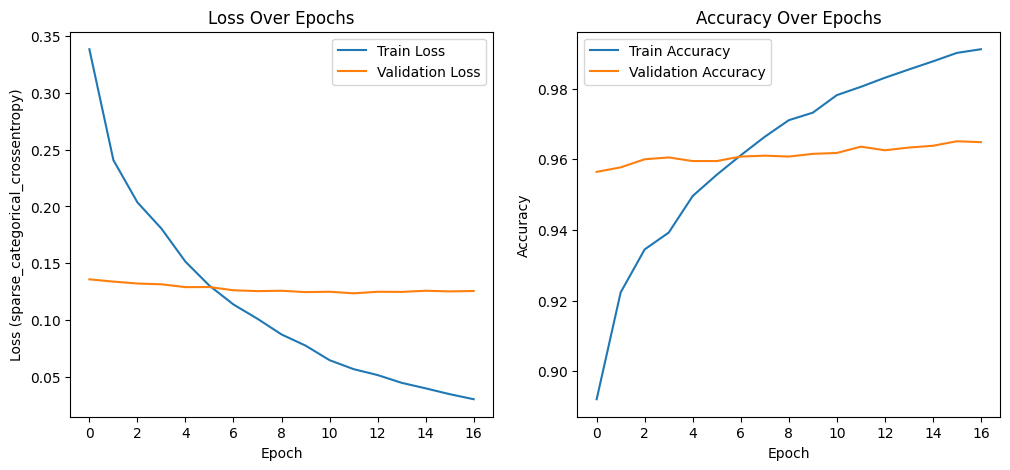

In [ ]:
import matplotlib.pyplot as plt

# The 'history' object contains the results of the second stage (fine-tuning)
# To see the full picture, you would ideally combine history_stage1 and history_stage2,
# but for visualization purposes, the fine-tuning stage is usually the most important.

def plot_training_history(history):
    plt.figure(figsize=(12, 5))

    # Plot Loss
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Loss Over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Loss (sparse_categorical_crossentropy)')
    plt.legend()

    # Plot Accuracy
    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Accuracy Over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.show()

# The 'history' variable was created in your Cell 3 code
print("--- Training History (Fine-Tuning Stage) ---")
plot_training_history(history)